# Table of Contents
 <p><div class="lev1"><a href="#Momentum-benchmark-summary"><span class="toc-item-num">1&nbsp;&nbsp;</span>Momentum benchmark summary</a></div><div class="lev1"><a href="#Load-backtest"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load backtest</a></div><div class="lev1"><a href="#Measure-performance"><span class="toc-item-num">3&nbsp;&nbsp;</span>Measure performance</a></div><div class="lev2"><a href="#Performance-by-futures-contract"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Performance by futures contract</a></div><div class="lev2"><a href="#Performance-by-asset-class"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Performance by asset class</a></div><div class="lev3"><a href="#Zoom-in-metal-momentum"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Zoom in metal momentum</a></div><div class="lev2"><a href="#Momentum-portfolio"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Momentum portfolio</a></div><div class="lev1"><a href="#Positions"><span class="toc-item-num">4&nbsp;&nbsp;</span>Positions</a></div>

# Momentum benchmark summary

This notebook displays the performance of time-series momentum strategies across major asset classes. Note that the all backtest should be taken with a grain of salt. Some assumptions are not realistic.

In [1]:
%matplotlib inline
import re 

import pandas as pd
import matplotlib.pyplot as plt

from adagio.stats.performance import Performance, PerfStats
from adagio.utils import keys
from adagio.utils.const import FuturesInfo
from adagio.utils.mongo import get_library

Connect to the database where the backtest result is saved.

In [2]:
library = get_library(keys.backtest)

# Load backtest

In [3]:
engine_symbol = library.list_symbols(name='engine_momentum')[0]
engine_item = library.read(engine_symbol)
engine = engine_item.data

In [4]:
def rename_contract(column_name):
    """ Convert key name into full name """
    fut_key = re.search('[A-Z]+_[A-Z]+', column_name)
    
    try:
        return FuturesInfo[fut_key.group(0)].value.full_name
    except AttributeError:
        return column_name
    
def rename_sub_returns(column_name):
    """ Rename strategy sub returns name """
    name = re.search('\([a-z_]+\)', column_name)
    
    try:
        name = name.group(0).replace('(', '').replace(')', '')
        return name
    except AttributeError:
        return column_name

# Measure performance

In [5]:
sub_net_returns = engine.sub_net_returns
final_net_returns = engine.final_net_returns
contract_net_returns = pd.concat([engine_sub.sub_net_returns for engine_sub in engine[0]], axis=1)

In [6]:
contract_net_returns = contract_net_returns.rename(columns=rename_contract)
sub_net_returns = sub_net_returns.rename(columns=rename_sub_returns)

## Performance by futures contract

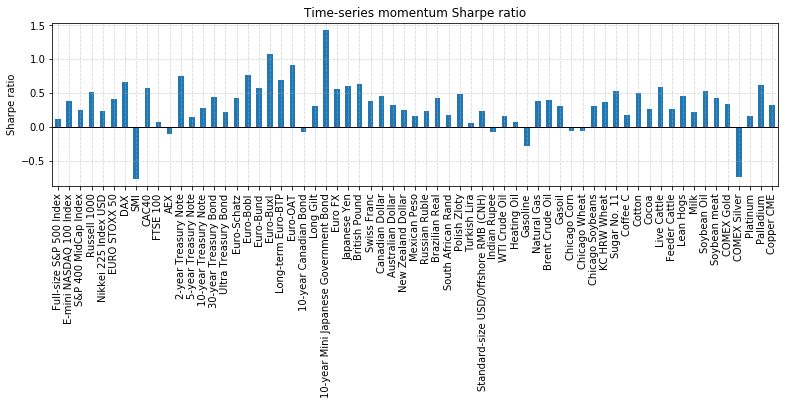

In [7]:
fig, ax = plt.subplots(figsize=(13, 3))
contract_net_returns.add(1).cumprod().pipe(Performance).summary()\
.loc[PerfStats.SHARPE.value, :].plot(kind='bar', ax=ax);

ax.set_title('Time-series momentum Sharpe ratio')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.axhline(0, color='black', lw=1);

## Performance by asset class

Only momentum applied to metal futures yielded negative Sharpe ratio for the backtest period. The underperformance is largely attributed to the drawdown occured in 1960s.

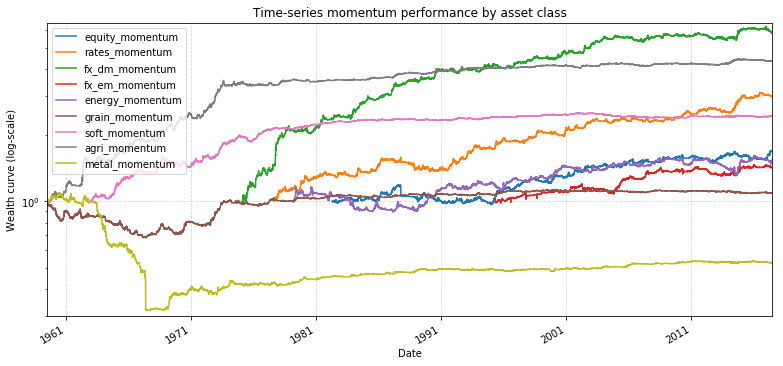

In [8]:
fig, ax = plt.subplots(figsize=(13, 6))
sub_net_returns.add(1).cumprod().plot(logy=True, ylim=(0.3, 6.5), ax=ax);
ax.set_title('Time-series momentum performance by asset class')
ax.set_ylabel('Wealth curve (log-scale)');

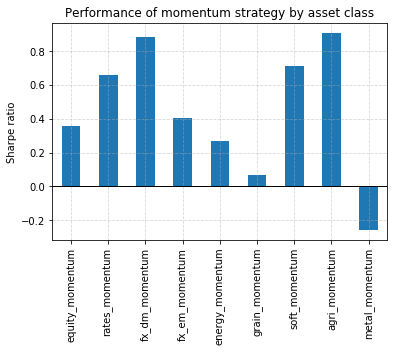

In [9]:
fig, ax = plt.subplots()
sub_net_returns.add(1).cumprod().pipe(Performance).summary().loc[PerfStats.SHARPE.value, :].plot(kind='bar', ax=ax)
ax.set_title('Performance of momentum strategy by asset class')
ax.set_ylabel(PerfStats.SHARPE.value)
ax.axhline(0, color='black', lw=1);

### Zoom in metal momentum

Silver futures seem to have caused the drawdown.

In [10]:
metal_sub_returns = engine[0][-1].sub_net_returns

In [11]:
metal_sub_returns = metal_sub_returns.rename(columns=rename_contract)

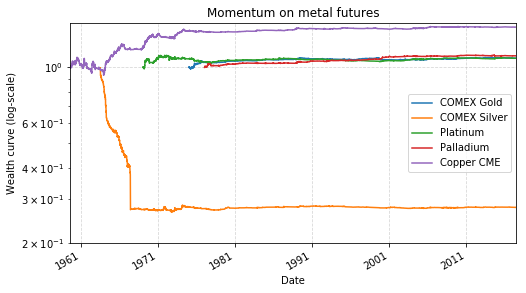

In [12]:
fig, ax = plt.subplots(figsize=(8, 4.5))
metal_sub_returns.add(1).cumprod().plot(logy=True, ylim=(0.2, 1.5), ax=ax);
ax.set_title('Momentum on metal futures')
ax.set_ylabel('Wealth curve (log-scale)');

Let's check with the long-only performance of the silver futures in order to see if this drawdown makes sense.

In [13]:
silver_lo_symbol = library.list_symbols(lo_ticker='CME_SI')[0]
silver_lo = library.read(silver_lo_symbol).data

Silver futures in 1967 bounced up largely after the gradual drawdown in the previous years. This behaviour is obviously not suitable for trend-following.

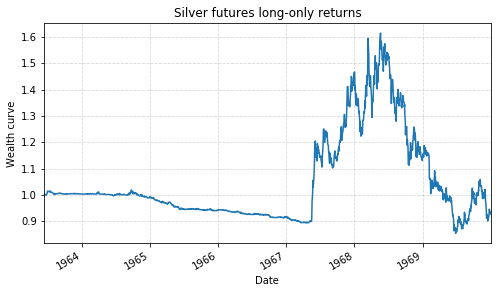

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))
silver_lo.final_net_returns[:'1969-12-31'].add(1).cumprod().plot(ax=ax);
ax.set_ylabel('Wealth curve')
ax.set_title('Silver futures long-only returns');

## Momentum portfolio

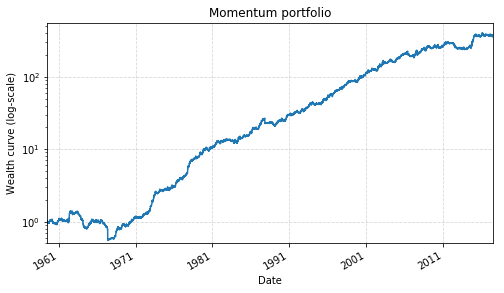

In [15]:
fig, ax = plt.subplots(figsize=(8, 4.5))
final_net_returns.add(1).cumprod().plot(logy=True, ylim=(0.5, 550), ax=ax);
ax.set_title('Momentum portfolio')
ax.set_ylabel('Wealth curve (log-scale)');

In [16]:
final_net_returns.add(1).cumprod().pipe(Performance).summary()

,final_net_returns (engine_momentum)
annualised return,0.105146
annualised vol,0.109744
Sharpe ratio,0.958103
max drawdown,0.607331
Calmar ratio,0.173128
skewness,-0.937600
kurtosis,12.419710


# Positions

The bar chart below shows the latest positions for each futures contract.

In [17]:
latest_position = pd.concat([sub_engine.sub_positions.tail(1) for sub_engine in engine[0]], axis=1)

In [18]:
latest_position = latest_position.rename(columns=rename_contract)

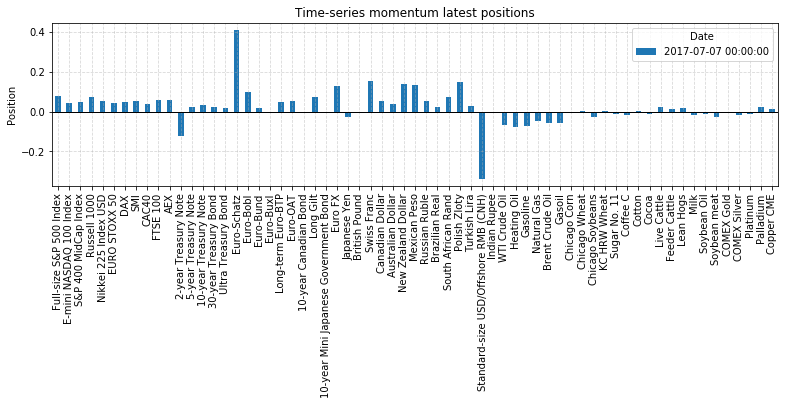

In [19]:
fig, ax = plt.subplots(figsize=(13, 3))
latest_position.T.plot(kind='bar', ax=ax);
ax.set_ylabel('Position')
ax.set_title('Time-series momentum latest positions')
ax.axhline(0, color='black', lw=1);